In [1]:
import os
import pandas as pd
import pytz
import matplotlib
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import seaborn as sns
import calendar
import numpy as np
import matplotlib.colors as mcolors
from datetime import datetime

%matplotlib inline

In [2]:
df = pd.read_parquet("path/to/surfsara_power_usage")

In [3]:
col_to_rack_name = dict()
for column in df.columns:
    rack = column.split("n")[0]
    
    if rack not in col_to_rack_name:
        col_to_rack_name[rack] = set()
    
    col_to_rack_name[rack].add(column)
    
gpu_nodes = {
    "r28n1", "r28n2", "r28n3", "r28n4", "r28n5",
    "r29n1", "r29n2", "r29n3", "r29n4", "r29n5",
    "r30n1", "r30n2", "r30n3", "r30n4", "r30n5", "r30n6", "r30n7",
    "r31n1", "r31n2", "r31n3", "r31n4", "r31n5", "r31n6"
    "r32n1", "r32n2", "r32n3", "r32n4", "r32n5", "r32n6", "r32n7",
    "r33n2", "r33n3", "r33n5", "r33n6",
    "r34n1", "r34n2", "r34n3", "r34n4", "r34n5", "r34n6", "r34n7",
    "r35n1", "r35n2", "r35n3", "r35n4", "r35n5",
    "r36n1", "r36n2", "r36n3", "r36n4", "r36n5",
    "r38n1", "r38n2", "r38n3", "r38n4", "r38n5",
}

In [58]:
# This and the next cell output a violin plot with the node power consumptions per rack
arrs = []
colors=[]

arrays = dict(
{
    "cpu_only": dict(),
    "cpu_gpu": dict()
})

for rack, columns in col_to_rack_name.items():
    arr = df[list(columns)].values.ravel()
    arr = arr[arr >= 0]  # Filter all non-zero values
    
    colors.append(mcolors.to_rgba("gray"))
    
    if any(c in gpu_nodes for c in columns):
#         colors.append(mcolors.to_rgba("red"))
        arrays["cpu_gpu"][rack] = arr
    else:
#         colors.append(mcolors.to_rgba("gray"))
        arrays["cpu_only"][rack] = arr

data = []
labels = []
pdf_max_values = []

def normalize(df):
    df = df.value_counts(sort=False, normalize=True).rename_axis('target').reset_index(name='pdf')
    df["cdf"] = df["pdf"].cumsum()
    return df

for k, v in sorted(arrays['cpu_only'].items(), key=lambda x: np.median(x[1])):
    value_list = list(v)
    data.append(value_list)
    
    bl = normalize(pd.DataFrame({"target": value_list}))
    
    index_max_pdf = bl["pdf"].idxmax()
    row_with_max = bl.iloc[index_max_pdf]
    pdf_max_values.append((row_with_max['target'], row_with_max['pdf']))
    labels.append("{}({})".format(k, len(col_to_rack_name[k])))
    
num_cpu_only = len(data)

for k, v in sorted(arrays['cpu_gpu'].items(), key=lambda x: np.median(x[1])):
    value_list = list(v)
    data.append(value_list)
    
    bl = normalize(pd.DataFrame({"target": value_list}))
    
    index_max_pdf = bl["pdf"].idxmax()
    row_with_max = bl.iloc[index_max_pdf]
    pdf_max_values.append((row_with_max['target'], row_with_max['pdf']))  # Store the target and PDF value of the max PDF value
    labels.append("{}({})".format(k, len(col_to_rack_name[k])))
    
num_cpu_gpu = len(data) - num_cpu_only   
    
del arrays
del bl

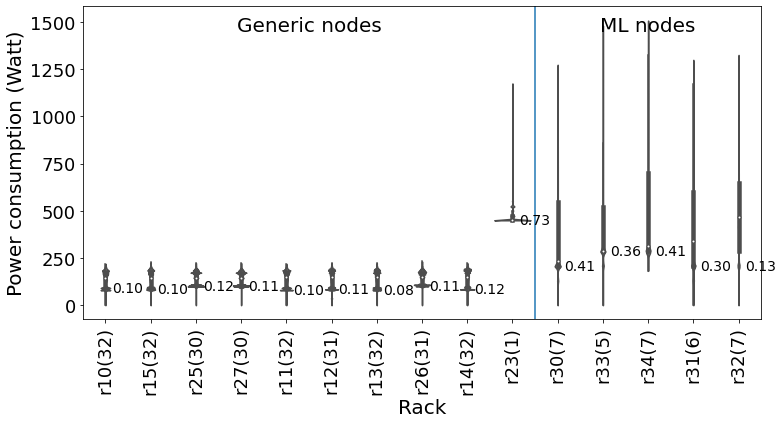

In [59]:
date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
fig, ax = plt.subplots(figsize=(11, 6))
sns.violinplot(data=data, ax=ax, yerr=arr.std(), capsize=5, palette=colors, cut=0)

    
ax.set_xlabel("Rack", fontsize=20)
ax.set_ylabel("Power consumption (Watt)", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

horizontal_indices = np.arange(len(labels))
ax.set_xticks(horizontal_indices)
ax.set_xticklabels(labels, rotation = 90)

for index in horizontal_indices:
    ax.text(x=index + 0.15, y=pdf_max_values[index][0], s="{:.2f}".format(pdf_max_values[index][1]), fontsize=14, color="black", va="center")

# Draw a horizontal line separating the two groups
ax.axvline(x = num_cpu_only - .5)
# Add text to show what the groups depict
ax.text((num_cpu_only / 2) / (num_cpu_only + num_cpu_gpu), 0.92, 'Generic nodes', horizontalalignment='center', transform=ax.transAxes, fontsize=20)
ax.text(((num_cpu_gpu / 2) +num_cpu_only)  / (num_cpu_only + num_cpu_gpu), 0.92, 'ML nodes', horizontalalignment='center', transform=ax.transAxes, fontsize=20)

fig.tight_layout()
fig.savefig("average_power_consumption_for_nodes_in_rack_violin_{}.pdf".format(date_time))

In [55]:
# This and the next cell output a violin plot with the summed node power consumptions per rack
arrs = []
colors=[]

arrays = dict(
{
    "cpu_only": dict(),
    "cpu_gpu": dict()
})

for rack, columns in col_to_rack_name.items():
    arr = df[list(columns)].fillna(0).replace(-1, 0).sum(axis=1).values.ravel()
    
    colors.append(mcolors.to_rgba("gray"))
    
    if any(c in gpu_nodes for c in columns):
#         colors.append(mcolors.to_rgba("red"))
        arrays["cpu_gpu"][rack] = arr
    else:
#         colors.append(mcolors.to_rgba("gray"))
        arrays["cpu_only"][rack] = arr

data = []
labels = []
pdf_max_values = []

def normalize(df):
    df = df.value_counts(sort=False, normalize=True).rename_axis('target').reset_index(name='pdf')
    df["cdf"] = df["pdf"].cumsum()
    return df

for k, v in sorted(arrays['cpu_only'].items(), key=lambda x: np.median(x[1])):
    value_list = list(v)
    data.append(value_list)
    
    bl = normalize(pd.DataFrame({"target": value_list}))
    
    index_max_pdf = bl["pdf"].idxmax()
    row_with_max = bl.iloc[index_max_pdf]
    pdf_max_values.append((row_with_max['target'], row_with_max['pdf']))
    labels.append("{}({})".format(k, len(col_to_rack_name[k])))
    
num_cpu_only = len(data)

for k, v in sorted(arrays['cpu_gpu'].items(), key=lambda x: np.median(x[1])):
    value_list = list(v)
    data.append(value_list)
    
    bl = normalize(pd.DataFrame({"target": value_list}))
    
    index_max_pdf = bl["pdf"].idxmax()
    row_with_max = bl.iloc[index_max_pdf]
    pdf_max_values.append((row_with_max['target'], row_with_max['pdf']))  # Store the target and PDF value of the max PDF value
    labels.append("{}({})".format(k, len(col_to_rack_name[k])))
    
num_cpu_gpu = len(data) - num_cpu_only  
    
del arrays

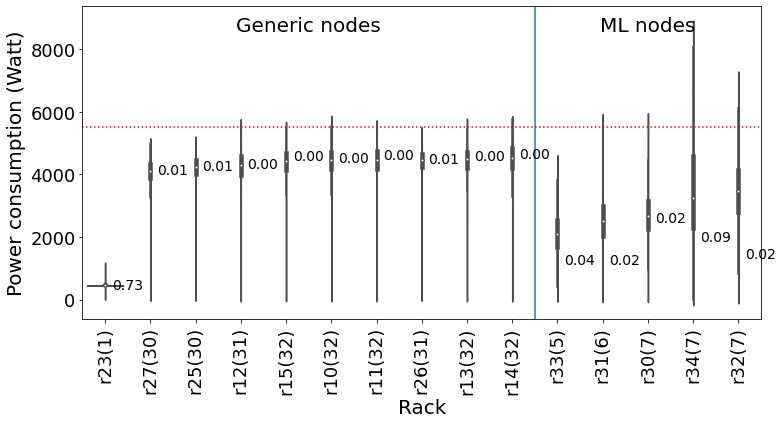

In [56]:
date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
fig, ax = plt.subplots(figsize=(11, 6))
sns.violinplot(data=data, ax=ax, yerr=arr.std(), capsize=5, palette=colors)

    
ax.set_xlabel("Rack", fontsize=20)
ax.set_ylabel("Power consumption (Watt)", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation = 90)

for index in horizontal_indices:
    ax.text(x=index + 0.15, y=pdf_max_values[index][0], s="{:.2f}".format(pdf_max_values[index][1]), fontsize=14, color="black", va="center")

# Draw a horizontal line separating the two groups
ax.axvline(x = num_cpu_only - .5)
# Add text to show what the groups depict
ax.text((num_cpu_only / 2) / (num_cpu_only + num_cpu_gpu), 0.92, 'Generic nodes', horizontalalignment='center', transform=ax.transAxes, fontsize=20)
ax.text(((num_cpu_gpu / 2) +num_cpu_only)  / (num_cpu_only + num_cpu_gpu), 0.92, 'ML nodes', horizontalalignment='center', transform=ax.transAxes, fontsize=20)

# Draw a dotted line to depict the cooling treshold
ax.axhline(y=5500, linestyle="dotted", color="red")

fig.tight_layout()
fig.savefig("average_power_consumption_per_rack_violin_{}.pdf".format(date_time))

In [4]:
gpu_values = np.array([])
non_gpu_values = np.array([])

for column in df.columns:
    arr = df[column].values
    mask = (np.isnan(arr) | (arr < 0))
    arr = arr[~mask]  # Filter out NaN values and less than 0
    if column in gpu_nodes:
        gpu_values = np.append(gpu_values, arr)
    else:
        non_gpu_values = np.append(non_gpu_values, arr)
        
del df

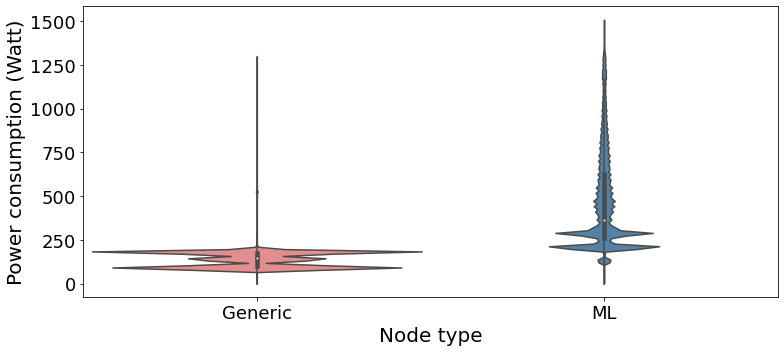

In [9]:
fig, ax = plt.subplots(figsize=(11,5))

colors = ['lightcoral', 'steelblue', 'yellowgreen']
     
sns.violinplot(data=[non_gpu_values, gpu_values], ax=ax, width=0.95, palette={0: "lightcoral", 1: "steelblue"}, cut=0)
ax.set_xlabel("Node type", fontsize=20)
ax.set_ylabel("Power consumption (Watt)", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

ax.set_xticks(np.arange(2))
ax.set_xticklabels(["Generic", "ML"])

fig.tight_layout()

date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
fig.savefig("power_consumption_gpu_vs_non_gpu_violin_{}.pdf".format(date_time))

In [7]:
t = '''\\begin{{table}}[t]
\\caption{{Power consumption statistics for generic and ML \\textit{{nodes}}. The header lists percentiles.}}
\\label{{surfing:tbl:power-consumption-percentiles-per-node-type}}
\\adjustbox{{max width=\\linewidth}}{{
\\begin{{tabular}}{{@{{}}lrrrrrrr@{{}}}}
\\toprule
    & $1^{{th}}$ & $25^{{th}}$ & median & mean & $75^{{th}}$ & $99^{{th}}$ \\\\ \\midrule
Generic & {0}    & {1}     & {2}     & {3}     & {4}     & {5}    \\\\
ML & {6}    & {7}     & {8}     & {9}     & {10}     & {11}    \\\\ \\bottomrule
\\end{{tabular}}
}}
\\end{{table}}'''

percentiles = [1, 25, 75, 99]
values = []

cpu_1, cpu_25, cpu_75, cpu_99 = np.percentile(non_gpu_values, percentiles)
cpu_mean = np.mean(non_gpu_values)
cpu_median = np.median(non_gpu_values)

gpu_1, gpu_25, gpu_75, gpu_99 = np.percentile(gpu_values, percentiles)
gpu_mean = np.mean(gpu_values)
gpu_median = np.median(gpu_values)

print(t.format(*["{:.2f}".format(v) for v in [
    cpu_1, cpu_25, cpu_median, cpu_mean, cpu_75, cpu_99,
    gpu_1, gpu_25, gpu_median, gpu_mean, gpu_75, gpu_99,
]]))

\begin{table}[t]
\caption{Power consumption statistics for CPU-only and GPU \textit{nodes}.}
\label{surfing:tbl:power-consumption-percentiles-per-node-type}
\adjustbox{max width=\linewidth}{
\begin{tabular}{@{}lrrrrrrr@{}}
\toprule
    & $1^{th}$ & $25^{th}$ & median & mean & $75^{th}$ & $99^{th}$ \\ \midrule
Generic & 80.00    & 100.00     & 148.00     & 143.01     & 176.00     & 260.00    \\
ML & 130.00    & 260.00     & 364.00     & 467.16     & 624.00     & 1274.00    \\ \bottomrule
\end{tabular}
}
\end{table}
